In [1]:
import gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from collections import deque

In [2]:
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LEARNING_RATE = 0.0005

n_episodes = 100000
hidden_dim = 128
min_eps = 0.01
max_eps_episode = 500

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import torch.nn as nn

class QNN(nn.Module):
    def __init__(self, ip_dim, op_dim, hid_dim) -> None:

        super(QNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(ip_dim, hid_dim),
            torch.nn.PReLU()
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(hid_dim, hid_dim),
            torch.nn.PReLU()
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(hid_dim, hid_dim),
            torch.nn.PReLU()
        )

        self.final = torch.nn.Linear(hid_dim, op_dim)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.layer1(t)
        t = self.layer2(t)
        t = self.layer3(t)
        t = self.final(t)

        return t

In [4]:
import random
from collections import namedtuple

transition = namedtuple('transition',('state', 'action', 'reward','nxt_state','stop'))

class ReplayMemory_CyclicBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push_to_memory(self, *args):
        self.memory.append(transition(*args))

    def random_sampling(self, batch_size):
        return random.sample(self.memory, batch_size)

In [5]:
import torch.optim as optim

from torch.autograd import Variable

BATCH_SIZE = 64
FloatTensor = torch.FloatTensor #32-bit float multi dimension matrix

class LunarLanderAgent(object):

    def __init__(self, n_states, n_actions, hidden_dim, learning_rate, gamma, tau):
        self.device = torch.device("cpu")
        self.local_q = QNN(n_states, n_actions, hidden_dim).to(self.device)
        self.target_q = QNN(n_states, n_actions, hidden_dim).to(self.device)

        self.mse_loss = torch.nn.MSELoss()
        self.optim = optim.Adam(self.local_q.parameters(), lr=learning_rate)

        self.n_actions = n_actions

        self.gamma = gamma
        self.tau = tau

        self.replay_memory = ReplayMemory_CyclicBuffer(10000)


    def get_action(self, state, eps_greedy, eps_flag = True):
        global steps_done

        random_sample = random.random()

        if random_sample > eps_greedy:
            with torch.no_grad():
                return self.local_q((state).type(FloatTensor)).data.max(1)[1].view(1,1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]])

    def learn(self):

        if len(self.replay_memory.memory) < BATCH_SIZE:
            return;

        transitions_sample = self.replay_memory.random_sampling(BATCH_SIZE)
        batch = transition(*zip(*transitions_sample))

        states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)
        nxt_states = torch.cat(batch.nxt_state)
        stops = torch.cat(batch.stop)

        expected_Q = torch.gather(self.local_q(states), 1, actions)
        nxt_targets_Q = self.target_q(nxt_states).detach().max(1)[0]
        targets_Q = rewards + (self.gamma * nxt_targets_Q * (1-stops)) #1-dones
        self.local_q.train(mode = True)
        self.optim.zero_grad()
        loss = self.mse_loss(expected_Q, targets_Q.unsqueeze(1))
        loss.backward()
        self.optim.step()

        self.soft_update(self.local_q, self.target_q)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


# Step 1. Install AI Gym, the instructions can be found at OpenAI-Lunar-LanderLinks to an external site.

In [6]:
!pip install swig

In [7]:
!pip install gym[box2d]

# Step 2. Import the environment

In [8]:
env = gym.make('LunarLander-v2')

lunar_space = env.observation_space.shape[0]
lunar_action = env.action_space.n

threshold = env.spec.reward_threshold

print('ip_dim:', lunar_space, 'op_dim:', lunar_action,'hidden_dim:', hidden_dim,'threshold:', threshold)

agent = LunarLanderAgent(lunar_space, lunar_action, hidden_dim, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU)

def epsilon_annealing(i_episode, max_episode, min_eps: float):

    slope = (min_eps - 1.0)/max_episode
    max_eps = max(slope * i_episode + 1.0, min_eps)
    return max_eps

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


ip_dim: 8 op_dim: 4 hidden_dim: 128 threshold: 200


In [9]:
def play_episode(env, agent, eps):

    state = env.reset()
    stop = False
    total_reward = 0

    while not stop:
        action = agent.get_action(FloatTensor([state]), eps)
        nxt_state, reward, stop, _ = env.step(action.item())
        total_reward = total_reward + reward

        if stop:
            reward = -1

        agent.replay_memory.push_to_memory(
            FloatTensor([state]),
            action,
            FloatTensor([reward]),
            FloatTensor([nxt_state]),
            FloatTensor([stop])
        )

        if(len(agent.replay_memory) > BATCH_SIZE):
            batch = agent.replay_memory.random_sampling(BATCH_SIZE)
            agent.learn()

        state = nxt_state

    return total_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Step 3. Train a model

In [10]:
def train():
    last_100_scores = deque(maxlen=100)
    all_scores = []
    avg_scores = []

    start_time = time.time()

    for i_episode in range(n_episodes):
        eps = epsilon_annealing(i_episode, max_eps_episode, min_eps)
        score = play_episode(env, agent, eps)

        last_100_scores.append(score)
        all_scores.append(score)

        avg_score = np.mean(last_100_scores)
        avg_scores.append(avg_score)

        dt = (int)(time.time() - start_time)

        if i_episode % 100 == 0 and i_episode > 0:
            print('Episode: {:5} Score: {:5}  Avg.Score: {:.2f}, eps-greedy: {:5.3f} Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, score, avg_score, eps, dt//3600, dt%3600//60, dt%60))

        if len(last_100_scores) == 100 and  avg_score >= threshold:
                print('\n Lunar Lander solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(last_100_scores)))
                break

    return all_scores, avg_scores

scores, avg_scores = train()


<ipython-input-9-238ea137b52d>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  action = agent.get_action(FloatTensor([state]), eps)


Episode:   100 Score: -97.75266924492932  Avg.Score: -142.22, eps-greedy: 0.802 Time: 00:00:35
Episode:   200 Score: -60.99750402276501  Avg.Score: -71.99, eps-greedy: 0.604 Time: 00:01:06
Episode:   300 Score: 1.598878525159435  Avg.Score: -22.45, eps-greedy: 0.406 Time: 00:02:19
Episode:   400 Score: -11.696474993699653  Avg.Score: 10.98, eps-greedy: 0.208 Time: 00:04:05
Episode:   500 Score: 278.66213447475326  Avg.Score: 120.00, eps-greedy: 0.010 Time: 00:06:25
Episode:   600 Score: 297.30584565553715  Avg.Score: 174.00, eps-greedy: 0.010 Time: 00:09:01
Episode:   700 Score: 293.9678653835723  Avg.Score: 146.06, eps-greedy: 0.010 Time: 00:11:23

 Lunar Lander solved in 786 episodes!	Average Score: 203.07


# Step 4. Discuss the parameters used to produce you training results

These parameters are mostly from the original demo
- GAMMA = 0.99: The discount rate
- TAU = 1e-3: The soft update rate for updating the target q network. It is used after every learn
- LEARNING_RATE = 0.0005: After different runs, this learning rate seems to give a more consistent result

- n_episodes = 100000: The max number of episodes to allow the agent to learn.
- hidden_dim = 128: The hidden dimension in the local and target networks
- min_eps = 0.01: The minimum epilson to determine where the next action comes from
- max_eps_episode = 500: Used to decay the epilson used. After the episode reach this value, the epilson will always be the min_eps

The success of the agents comes from the right learning rate and also the soft update rate that helps the target q to leran.


In [11]:
torch.save(agent.target_q, "LunarLander")

In [12]:
agent.target_q = torch.load("LunarLander")


In [13]:
score = play_episode(env, agent, 0.01)

In [14]:
score

271.27782355737236

scores length:  787 , avg_scores length:  787


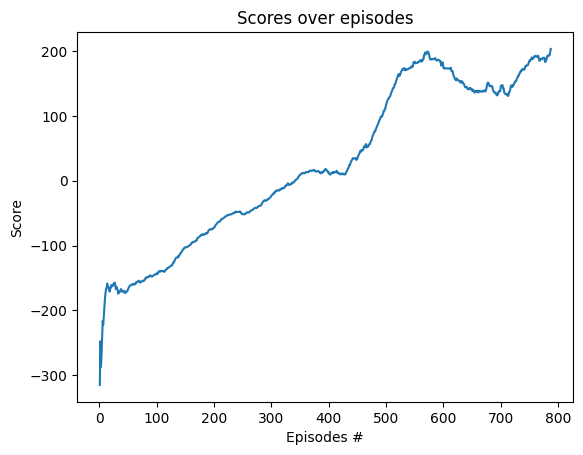

In [19]:
print('scores length: ', len(scores), ', avg_scores length: ', len(avg_scores))
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.title('Scores over episodes')
plt.show()

In [16]:
import glob
import base64, io
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display


def show_video(env_name):
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = '{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="{}.mp4".format(env_name))
    agent.local_q = torch.load('LunarLander')
    agent.target_q = torch.load('LunarLander')
    state = env.reset()
    stop = False
    while not stop:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.get_action(FloatTensor([state]), 0)

        nxt_state, reward, stop, _ = env.step(action.item())
    env.close()


In [17]:
lunar_agent = LunarLanderAgent(lunar_space, lunar_action, hidden_dim, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU)
show_video_of_model(lunar_agent, 'LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

# Step 5. Play an episode of the problem using your agent.

In [18]:
show_video('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Step 6. Discuss the results in terms of success rate

In terms of success rate, this agent still has much to improve from. From what we can see now, the video is showing us the spaceship is landing head first and it's starting from a very beneficial position. In other runs, it might fall to another area and showing an unsuccessful run. Therefore, to improve this agent, it will require more training so that the average score will be higher.